<a href="https://colab.research.google.com/github/realnihal/Predicting-stock-prices-using-ml/blob/main/Nihal's(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
from datetime import datetime
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt

#**Getting** **basic data**

In [72]:
start = datetime(1999, 3, 9)
end = datetime.today()
yahoo = web.DataReader('AMZN','yahoo',start=start,end=end)
yahoo.info
data = yahoo

In [73]:
data.to_csv('DATA.csv')
data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-10-27,3291.659912,3211.300049,3224.939941,3286.330078,4291000.0,3286.330078
2020-10-28,3264.020020,3162.469971,3249.300049,3162.780029,5588300.0,3162.780029
2020-10-29,3257.250000,3164.000000,3201.270020,3211.010010,6596500.0,3211.010010
2020-10-30,3167.000000,3019.000000,3157.750000,3036.149902,8386400.0,3036.149902
2020-11-02,3079.709961,2950.120117,3061.739990,3004.479980,7241400.0,3004.479980


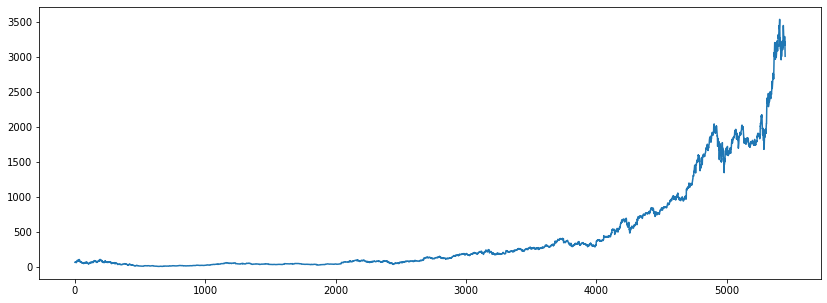

In [40]:
df = data.reset_index()['Close']
plt.figure(figsize = (14,5))
plt.plot(df)
plt.show()

In [41]:
data.describe()

,High,Low,Open,Close,Volume,Adj Close
count,5451.000000,5451.000000,5451.000000,5451.000000,5.451000e+03,5451.000000
mean,441.470740,431.009636,436.519970,436.460029,6.835996e+06,436.460029
std,677.941509,661.754819,670.474734,670.097193,5.599317e+06,670.097193
min,6.100000,5.510000,5.910000,5.970000,8.813000e+05,5.970000
25%,43.200001,41.617500,42.377501,42.439999,3.688650e+06,42.439999
50%,122.480003,118.010002,120.309998,120.099998,5.537000e+06,120.099998
75%,435.385010,428.020004,431.164993,431.004990,8.048450e+06,431.004990
max,3552.250000,3486.689941,3547.000000,3531.449951,1.043292e+08,3531.449951


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5451 entries, 1999-03-09 to 2020-11-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5451 non-null   float64
 1   Low        5451 non-null   float64
 2   Open       5451 non-null   float64
 3   Close      5451 non-null   float64
 4   Volume     5451 non-null   float64
 5   Adj Close  5451 non-null   float64
dtypes: float64(6)
memory usage: 298.1 KB


In [43]:
df.describe()

count    5451.000000
mean      436.460029
std       670.097193
min         5.970000
25%        42.439999
50%       120.099998
75%       431.004990
max      3531.449951
Name: Close, dtype: float64

#**Creating more features**

In [44]:
#closing prices to opening prices (changes) net gain in day
features = pd.DataFrame(index=df.index).sort_index()
features['f01'] = data.reset_index()['Close']/data.reset_index()['Open']-1
features.head()

,f01
0,0.038462
1,0.002742
2,-0.034884
3,-0.005131
4,0.044643


In [45]:
#opening prices compared to previous days closing prices (changes)
array = data.reset_index()['Open']/data.reset_index()['Close'].shift(-1)-1
features['f02'] = array
features.tail()

,f01,f02
5446,0.019036,0.019654
5447,-0.026627,0.011925
5448,0.003043,0.054385
5449,-0.038508,0.051014
5450,-0.018702,NaN


In [46]:
#volume logs
array = data.reset_index()['Volume'].apply(np.log)
features['f03'] = array
features.tail()

,f01,f02,f03
5446,0.019036,0.019654,15.272030
5447,-0.026627,0.011925,15.536186
5448,0.003043,0.054385,15.702050
5449,-0.038508,0.051014,15.942122
5450,-0.018702,NaN,15.795325


In [47]:
#volume difference to previous day
array = data.reset_index()['Volume'].diff()
features['f04'] = array
features.head()

,f01,f02,f03,f04
0,0.038462,-0.087511,16.606185,NaN
1,0.002742,0.013902,16.462933,-2174400.0
2,-0.034884,0.048289,16.603739,2134600.0
3,-0.005131,-0.035538,16.049024,-6919600.0
4,0.044643,-0.006072,15.764388,-2311800.0


In [48]:
#log of 5 days moving average of volume
ma_5 = lambda x : x.rolling(5).mean()
array = data.reset_index()['Volume'].rolling(5,min_periods=1).mean().apply(np.log)
features['f05'] = array
features.head()

,f01,f02,f03,f04,f05
0,0.038462,-0.087511,16.606185,NaN,16.606185
1,0.002742,0.013902,16.462933,-2174400.0,16.537122
2,-0.034884,0.048289,16.603739,2134600.0,16.559824
3,-0.005131,-0.035538,16.049024,-6919600.0,16.454468
4,0.044643,-0.006072,15.764388,-2311800.0,16.349449


In [49]:
#z_score for closing prices
array = (df - df.rolling(200,min_periods=1).mean())/df.rolling(200,min_periods=1).std()
features['f06'] = array
features.tail()

,f01,f02,f03,f04,f05,f06
5446,0.019036,0.019654,15.272030,-1610200.0,15.317969,1.267486
5447,-0.026627,0.011925,15.536186,1297300.0,15.361335,1.028543
5448,0.003043,0.054385,15.702050,1008200.0,15.458140,1.107563
5449,-0.038508,0.051014,15.942122,1789900.0,15.632398,0.773956
5450,-0.018702,NaN,15.795325,-1145000.0,15.675041,0.706880


In [50]:
#signing
array = features['f01'].apply(np.sign)
features['f07'] = array
features.tail()

,f01,f02,f03,f04,f05,f06,f07
5446,0.019036,0.019654,15.272030,-1610200.0,15.317969,1.267486,1.0
5447,-0.026627,0.011925,15.536186,1297300.0,15.361335,1.028543,-1.0
5448,0.003043,0.054385,15.702050,1008200.0,15.458140,1.107563,1.0
5449,-0.038508,0.051014,15.942122,1789900.0,15.632398,0.773956,-1.0
5450,-0.018702,NaN,15.795325,-1145000.0,15.675041,0.706880,-1.0


In [51]:
#plus-minus how many days the value has increased or decreased
array = features['f07'].rolling(200,min_periods=1).sum()
features['f08'] = array
features.head()

,f01,f02,f03,f04,f05,f06,f07,f08
0,0.038462,-0.087511,16.606185,NaN,16.606185,NaN,1.0,1.0
1,0.002742,0.013902,16.462933,-2174400.0,16.537122,0.707107,1.0,2.0
2,-0.034884,0.048289,16.603739,2134600.0,16.559824,0.243662,-1.0,1.0
3,-0.005131,-0.035538,16.049024,-6919600.0,16.454468,-0.165545,-1.0,0.0
4,0.044643,-0.006072,15.764388,-2311800.0,16.349449,1.178915,1.0,1.0


#**Creating TA technical indicator features**

In [52]:
pip install --upgrade ta

Requirement already up-to-date: ta in /usr/local/lib/python3.6/dist-packages (0.5.25)


In [53]:
import ta

In [54]:
ta_data = data
ta_data.shape

(5451, 6)

In [55]:
#making sure there are no missing values
ta_data = ta.utils.dropna(ta_data)

In [56]:
ta_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5451 entries, 1999-03-09 to 2020-11-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       5451 non-null   float64
 1   Low        5451 non-null   float64
 2   Open       5451 non-null   float64
 3   Close      5451 non-null   float64
 4   Volume     5451 non-null   float64
 5   Adj Close  5451 non-null   float64
dtypes: float64(6)
memory usage: 298.1 KB


In [57]:
ta_data = ta.add_all_ta_features(ta_data,'Open','High','Low','Close','Volume',fillna=True)
ta_data.head()

/usr/local/lib/python3.6/dist-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/usr/local/lib/python3.6/dist-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


,High,Low,Open,Close,Volume,Adj Close,volume_adi,volume_obv,volume_cmf,volume_fi,momentum_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,trend_macd,trend_macd_signal,trend_macd_diff,trend_sma_fast,trend_sma_slow,trend_ema_fast,trend_ema_slow,trend_adx,trend_adx_pos,trend_adx_neg,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,momentum_rsi,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1999-03-09,66.62500,61.71875,62.5625,64.96875,16292000.0,64.96875,5.292306e+06,16292000.0,0.324841,0.000000e+00,50.000000,0.000000,0.000000,-1.383587e+07,1000.000000,64.437500,0.0,64.968750,64.968750,64.968750,0.000000,0.000000,0.0,0.0,64.437500,69.343750,59.531250,15.227934,0.554140,0.0,0.0,7.551708,0.662420,0.000000,0.000000,0.000000,64.968750,64.968750,64.968750,64.968750,0.0,0.0,0.0,0.000000,0.000000,0.000000,-84.691083,1.000000,0.000000,371.491279,-851.146163,-851.146163,0.000000,64.171875,64.171875,64.171875,64.171875,430.908175,420.893514,4.0,4.0,0.0,-1.0,-1.0000,0.0,0.0,100.000000,0.000000,0.000000,66.242038,66.242038,-33.757962,0.0,64.968750,0.0,-85.114616,0.000000,0.000000
1999-03-10,69.46875,67.00000,68.3750,68.56250,14117600.0,68.56250,9.045085e+06,30409600.0,0.297442,5.073512e+07,100.000000,71.041090,71.041090,-1.308596e+07,1055.315055,66.250969,0.0,66.765625,70.359375,63.171875,10.765270,0.750000,0.0,0.0,66.390625,70.078125,62.703125,11.108496,0.794492,0.0,0.0,11.607770,0.883065,0.286681,0.057336,0.229345,66.765625,66.765625,65.521635,65.234954,0.0,0.0,0.0,0.020436,0.000989,0.019447,0.010804,1.918898,66.666667,369.694404,-847.029234,-849.087698,2.058465,65.593750,65.593750,65.593750,65.593750,430.908175,420.893514,8.0,4.0,4.0,-1.0,-1.0000,0.0,0.0,100.000000,100.000000,38.205980,88.306452,77.274245,-11.693548,0.0,66.740358,0.0,5.531506,5.383935,5.531506
1999-03-11,71.37500,65.50000,69.8750,67.43750,16252200.0,67.43750,3.512422e+06,14157400.0,0.075274,4.087529e+07,46.573024,7.342756,39.191923,5.142434e+05,1055.315055,66.896434,0.0,66.989583,69.991464,63.987703,8.962230,0.574606,0.0,0.0,66.961806,71.378472,62.545139,13.191600,0.553852,0.0,0.0,14.414555,0.592233,0.418278,0.129525,0.288753,66.989583,66.989583,65.816383,65.398105,0.0,0.0,0.0,0.031484,0.011279,0.020205,0.024975,2.902402,45.254470,369.470445,-846.516109,-848.230502,1.714393,66.546875,66.546875,66.546875,66.546875,430.908175,420.893514,8.0,4.0,4.0,-1.0,66.6250,0.0,1.0,74.787394,99.306759,36.196319,59.223301,71.257264,-40.776699,0.0,67.082307,0.0,-1.640839,-1.654450,3.799904
1999-03-12,67.68750,64.31250,67.0000,66.65625,9332600.0,66.65625,7.141766e+06,4824800.0,0.127544,3.399438e+07,35.872215,-88.148667,-3.254940,-3.747887e+05,1043.089441,66.783484,0.0,66.906250,69.521933,64.290567,7.818949,0.452211,0.0,0.0,66.776042,70.932292,62.619792,12.448327,0.485589,0.0,0.0,14.432508,0.511327,0.454292,0.194478,0.259814,66.906250,66.906250,65.945593,65.491301,0.0,0.0,0.0,0.036841,0.029360,0.007481,0.038389,3.843755,-25.659472,369.553779,-846.707039,-847.849636,1.142597,66.546875,66.546875,66.546875,66.546875,430.908175,420.893514,8.0,4.0,4.0,65.5,66.6250,1.0,0.0,62.922913,98.259043,42.211055,51.132686,66.220813,-48.867314,0.0,66.869900,0.0,-1.158480,-1.165243,2.597403
1999-03-15,69.50000,65.50000

In [58]:
ta_data.shape

(5451, 78)

In [59]:
#selecting a few features
selected_features = [
                     'volume_adi',
                     'volume_fi',
                     'volatility_bbm',
                     'trend_macd',
                     'trend_vortex_ind_diff',
                     'momentum_rsi',
                     'Close',
                     'trend_cci',
                     'volatility_kcw',
                     'trend_dpo'
                     ]
for i in selected_features:
  array = ta_data.reset_index()[i]
  features[i] = array
features.head()

,f01,f02,f03,f04,f05,f06,f07,f08,volume_adi,volume_fi,volatility_bbm,trend_macd,trend_vortex_ind_diff,momentum_rsi,Close,trend_cci,volatility_kcw,trend_dpo
0,0.038462,-0.087511,16.606185,NaN,16.606185,NaN,1.0,1.0,5.292306e+06,0.000000e+00,64.968750,0.000000,0.000000,100.000000,64.96875,0.000000,15.227934,371.491279
1,0.002742,0.013902,16.462933,-2174400.0,16.537122,0.707107,1.0,2.0,9.045085e+06,5.073512e+07,66.765625,0.286681,0.019447,100.000000,68.56250,66.666667,11.108496,369.694404
2,-0.034884,0.048289,16.603739,2134600.0,16.559824,0.243662,-1.0,1.0,3.512422e+06,4.087529e+07,66.989583,0.418278,0.020205,74.787394,67.43750,45.254470,13.191600,369.470445
3,-0.005131,-0.035538,16.049024,-6919600.0,16.454468,-0.165545,-1.0,0.0,7.141766e+06,3.399438e+07,66.906250,0.454292,0.007481,62.922913,66.65625,-25.659472,12.448327,369.553779
4,0.044643,-0.006072,15.764388,-2311800.0,16.349449,1.178915,1.0,1.0,1.405287e+07,3.195889e+07,67.418750,0.701690,0.015048,77.042704,69.46875,53.373615,12.303868,369.041279


#**Feature Selection**

#normalization


In [60]:
from sklearn.preprocessing import StandardScaler,Normalizer

In [61]:
#normalizing the inputs
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna())
features_scaled.shape

(5449, 18)

In [62]:
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.head()

,f01,f02,f03,f04,f05,f06,f07,f08,volume_adi,volume_fi,volatility_bbm,trend_macd,trend_vortex_ind_diff,momentum_rsi,Close,trend_cci,volatility_kcw,trend_dpo
1,0.068598,0.328393,1.557143,-0.446370,1.776451,0.059130,0.992873,0.006873,-1.323627,1.304182,-0.552371,-0.216857,-0.169125,3.805619,-0.549125,0.414785,0.795541,14.040357
2,-1.269346,1.129127,1.795312,0.438790,1.818892,-0.284740,-1.011634,-0.051733,-1.331335,1.033589,-0.552031,-0.209260,-0.166759,1.741418,-0.550806,0.223504,1.228033,14.031855
3,-0.211353,-0.822848,0.857027,-1.421134,1.621932,-0.588367,-1.011634,-0.110338,-1.326279,0.844750,-0.552158,-0.207181,-0.206471,0.770052,-0.551974,-0.409987,1.073716,14.035018
4,1.558545,-0.136713,0.375571,-0.474594,1.425601,0.409206,0.992873,-0.051733,-1.316649,0.788889,-0.551380,-0.192900,-0.182853,1.926064,-0.547771,0.296035,1.043723,14.015562
5,-1.355983,1.426719,0.494993,0.105802,1.145867,-0.667464,-1.011634,-0.110338,-1.324221,0.587898,-0.551509,-0.193973,-0.171000,0.210272,-0.551600,0.129010,1.006646,14.018805


In [63]:
input_df = df
output_df = df['Close'] 
print(output_df.tail())


5445    4.140517
5446    4.258995
5447    4.074382
5448    4.146449
5449    3.885166
Name: Close, dtype: float64


In [64]:
corr = input_df.corrwith(output_df)
corr

f01                     -0.014465
f02                     -0.006899
f03                     -0.307980
f04                      0.001058
f05                     -0.357494
f06                      0.275631
f07                     -0.002334
f08                     -0.031491
volume_adi               0.669806
volume_fi                0.106866
volatility_bbm           0.998479
trend_macd               0.493306
trend_vortex_ind_diff    0.128390
momentum_rsi             0.161057
Close                    1.000000
trend_cci                0.119577
volatility_kcw          -0.338955
trend_dpo               -0.077812
dtype: float64

In [65]:
selected_columns = corr[corr>0.1].index.to_list()
corr = input_df[selected_columns].corrwith(output_df)
corr

f06                      0.275631
volume_adi               0.669806
volume_fi                0.106866
volatility_bbm           0.998479
trend_macd               0.493306
trend_vortex_ind_diff    0.128390
momentum_rsi             0.161057
Close                    1.000000
trend_cci                0.119577
dtype: float64

In [66]:
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance

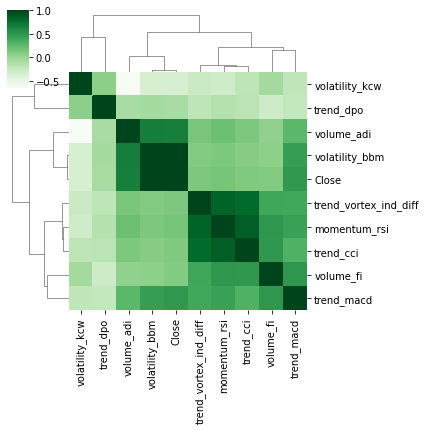

In [67]:
corr_matrix = input_df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)
linkage = hierarchy.linkage(distance.pdist(correlations_array),method='average')
g=sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

In [68]:
#ignore the close input
label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength")
print(corr[corr>0.1].sort_values(ascending=False))

Correlation Strength
Close                    1.000000
volatility_bbm           0.998479
volume_adi               0.669806
trend_macd               0.493306
f06                      0.275631
momentum_rsi             0.161057
trend_vortex_ind_diff    0.128390
trend_cci                0.119577
volume_fi                0.106866
dtype: float64


In [69]:
input_df.head()

,f01,f02,f03,f04,f05,f06,f07,f08,volume_adi,volume_fi,volatility_bbm,trend_macd,trend_vortex_ind_diff,momentum_rsi,Close,trend_cci,volatility_kcw,trend_dpo
1,0.068598,0.328393,1.557143,-0.446370,1.776451,0.059130,0.992873,0.006873,-1.323627,1.304182,-0.552371,-0.216857,-0.169125,3.805619,-0.549125,0.414785,0.795541,14.040357
2,-1.269346,1.129127,1.795312,0.438790,1.818892,-0.284740,-1.011634,-0.051733,-1.331335,1.033589,-0.552031,-0.209260,-0.166759,1.741418,-0.550806,0.223504,1.228033,14.031855
3,-0.211353,-0.822848,0.857027,-1.421134,1.621932,-0.588367,-1.011634,-0.110338,-1.326279,0.844750,-0.552158,-0.207181,-0.206471,0.770052,-0.551974,-0.409987,1.073716,14.035018
4,1.558545,-0.136713,0.375571,-0.474594,1.425601,0.409206,0.992873,-0.051733,-1.316649,0.788889,-0.551380,-0.192900,-0.182853,1.926064,-0.547771,0.296035,1.043723,14.015562
5,-1.355983,1.426719,0.494993,0.105802,1.145867,-0.667464,-1.011634,-0.110338,-1.324221,0.587898,-0.551509,-0.193973,-0.171000,0.210272,-0.551600,0.129010,1.006646,14.018805


# **Backtesting and prediction loop**

In [124]:
series = input_df
output = output_df
X = series.values
n_train = 504
n_records = len(X)
acc_results = output[504:len(X)]
def model_train(model):
  prediction = np.empty(shape=(0,0))
  for i in range(n_train, n_records):
    train_x,test_x=X[(i-n_train)+0:i],X[i:i+1]
    train_y,test_y=output[(i-n_train)+0:i],output[i:i+1]
    model.fit(train_x,train_y)
    pred_value = model.predict(test_x)
    prediction = np.append(prediction,pred_value)
  return prediction

###**defining models**

In [123]:
from sklearn.tree import DecisionTreeRegressor
regression_tree_model = DecisionTreeRegressor(criterion='friedman_mse',
                                              max_depth=10,
                                              min_samples_leaf=50)
regression_tree_model.fit(train_x,train_y)
pred_value = regression_tree_model.predict(test_x)
value = pred_value-test_y
pred_value

array([3.48586609])

In [122]:
predictions = model_train(regression_tree_model)
predictions

array([-0.62298818, -0.62311903, -0.62323706, ...,  4.18038867,
        4.17867888,  3.48586609])

In [130]:
from sklearn.metrics import mean_squared_error
tree_mse = mean_squared_error(acc_results,predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.10817829495685913